In [67]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('ES7-26-22_to_9-18-24.csv')

#testing random feature drops
data = data.drop(columns='FT')
#data = data.drop(columns='FullK')
#data = data.drop(columns='diffKD')
#data = data.drop(columns='OB')
#data = data.drop(columns='OS')
#data = data.drop(columns='vol')
#data = data.drop(columns='s15')
#data = data.drop(columns='s30')
#data = data.drop(columns='s60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='Inertias')
#data = data.drop(columns='percBB')
#data = data.drop(columns='spreadRSI')
#data = data.drop(columns='ADX')
#data = data.drop(columns='RSI')
#data = data.drop(columns='Wpercent')
#data = data.drop(columns='acc')

#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='bull15')
data = data.drop(columns='bear15')
data = data.drop(columns='bull30')
data = data.drop(columns='bear30')
data = data.drop(columns='bull60')
data = data.drop(columns='bear60')

#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

NinRows = data.drop(data[data['bull15'] == 'in'].index)
inRows = data.drop(data[data['bull15'] != 'in'].index)

inRowsMatch = inRows.loc[0:17129]

print('ins -\t',inRows.index.size,'\ninsMatch -\t',\
      inRowsMatch.index.size,'\nnon-ins -\t',NinRows.index.size)

optData = pd.concat([NinRows, inRowsMatch],axis=0)

percIn = data.size/(inRows.size*2)
percNin = data.size/(NinRows.size*2)
weight_for_0 = .5
weight_for_1 = .5
cw = {0: weight_for_0, 1: weight_for_1}

print("PERCENT & WEIGHTS:\nINS\t-\t",percIn*100," %\nNon-INS\t-\t",percNin*100," %",sep='')
print('\n\nActual Weights:\nweight_for_0: ',weight_for_0,'\nweight_for_1: ',weight_for_1,sep='',end='')

print("OCCURANCES IN OPT DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

smote = SMOTE()
X, y = smote.fit_resample(X,y)
print('\n[PRE-SPLIT] Resampled Data size:',X.size)

#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    0.4,
    decay_steps=32000,
    decay_rate=0.99,
    staircase=True)

opt1 = SGD(learning_rate=0.001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.7)
opt3 = SGD(learning_rate=lr_schedule)

def build_model():
    model = tf.keras.Sequential([#currently 17 total features
        tf.keras.layers.Dense(128, input_dim=16, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.Dense(128, activation='leaky_relu'),
        #tf.keras.layers.Dropout(0.3),
        #tf.keras.layers.Dense(256, activation='leaky_relu'),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    met = ['Accuracy','AUC','Precision','Recall','TrueNegatives','TruePositives','FalsePositives','FalseNegatives']

    
    def custom_loss(y_true, y_pred):
        
        # Standard binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Define penalties for false negatives (y_true = 1, y_pred = 0)
        false_negatives_penalty = 10.0  # Penalty for false negatives
        false_positives_penalty = 10.0  # Penalty for false positives
        
        # Define reward for true positives (y_true = 1, y_pred = 1)
        true_positives_reward = -20.0  # Negative value to reduce the loss when TP happens

        # Calculate false negatives and false positives
        false_negatives = y_true * (1 - y_pred)
        false_positives = (1 - y_true) * y_pred
        
        # Calculate true positives
        true_positives = y_true * y_pred
        
        # Apply penalties and rewards
        penalties = false_negatives_penalty * false_negatives + false_positives_penalty * false_positives
        rewards = true_positives_reward * true_positives
        
        # Return combined loss (penalize FNs and FPs, reward TPs)
        return bce + penalties + rewards

    

    model.compile(optimizer=opt3, loss=custom_loss, metrics=met)

    return model


def load_model():
    loaded_model = tf.keras.models.load_model('acc77.keras')

    met = ['Accuracy','AUC','Precision','Recall','TrueNegatives','TruePositives','FalsePositives','FalseNegatives']
    
    #tf.keras.saving.get_custom_objects().clear()
    #@tf.keras.saving.register_keras_serializable(package="my_package", name="custom_loss")
    def custom_loss(y_true, y_pred):
        
        # Standard binary cross-entropy
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # Define penalties for false negatives (y_true = 1, y_pred = 0)
        false_negatives_penalty = 0.0  # Penalty for false negatives
        false_positives_penalty = 5.0  # Penalty for false positives
        
        # Define reward for true positives (y_true = 1, y_pred = 1)
        true_positives_reward = -2.0  # Negative value to reduce the loss when TP happens

        # Calculate false negatives and false positives
        false_negatives = y_true * (1 - y_pred)
        false_positives = (1 - y_true) * y_pred
        
        # Calculate true positives
        true_positives = y_true * y_pred
        
        # Apply penalties and rewards
        penalties = false_negatives_penalty * false_negatives + false_positives_penalty * false_positives
        rewards = true_positives_reward * true_positives
        
        # Return combined loss (penalize FNs and FPs, reward TPs)
        return bce + penalties + rewards

    loaded_model.compile(optimizer=opt3, loss=custom_loss, metrics=met)

    return loaded_model


#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 100

early_stopping = []#EarlyStopping(monitor='val_Recall', patience=5, mode='max', restore_best_weights=True)

model = build_model()
loaded_model = load_model()
history = loaded_model.fit(X, y, epochs=epochs, validation_split=0.2,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    class_weight=cw, callbacks=early_stopping)

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY
plt.plot(epochs, history.history['Accuracy'], 'y', label='Training acc')
plt.plot(epochs, history.history['val_Accuracy'], 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# AUC
plt.plot(epochs, history.history['AUC'], 'y', label='Training AUC')
plt.plot(epochs, history.history['val_AUC'], 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# PRECISION
plt.plot(epochs, history.history['Precision'], 'y', label='Training Precision')
plt.plot(epochs, history.history['val_Precision'], 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# RECALL
plt.plot(epochs, history.history['Recall'], 'y', label='Training Recall')
plt.plot(epochs, history.history['val_Recall'], 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# TPR
'''
TPR = history.history['TruePositives']/(history.history['TruePositives']+history.history['TrueNegatives'])
val_TPR = history.history['val_TruePositives']/(history.history['val_TruePositives']+history.history['val_TrueNegatives'])
plt.plot(epochs, TPR, 'y', label='Training TPR')
plt.plot(epochs, val_TPR, 'r', label='Validation TPR')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('TP Rate')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''

#predicting the test set results
y_pred = loaded_model.predict(X_test)
y_pred = (y_pred > 0.5)

#making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

# Save the model
#model.save('epoch15k.keras')
# Load the model
#loaded_model = tf.keras.models.load_model('my_model.keras')

TESTED FEATURES: 
Index(['FullK', 'diffKD', 'OB', 'OS', 'vol', 's15', 's30', 's60', 'ToD',
       'Inertias', 'percBB', 'spreadRSI', 'ADX', 'RSI', 'Wpercent', 'acc'],
      dtype='object')
TESTING FOR: 
bull15
OCCURANCES IN RAW DATA FOR bull15: 
{'in': 137027, 'up': 15476}
ins -	 137027 
insMatch -	 15476 
non-ins -	 15476
PERCENT & WEIGHTS:
INS	-	55.647062257803206 %
Non-INS	-	492.70806409925046 %


Actual Weights:
weight_for_0: 0.5
weight_for_1: 0.5OCCURANCES IN OPT DATA FOR bull15: 
{'in': 15476, 'up': 15476}

[PRE-SPLIT] Resampled Data size: 4384864


c:\Users\logan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

In [24]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
TP = history.history['TruePositives'][-1]
FP = history.history['FalsePositives'][-1]
TN = history.history['TrueNegatives'][-1]
FN = history.history['FalseNegatives'][-1]
weight_for_0 = (1 / TN) * ((TN+FN) / 4.0)
weight_for_1 = (1 / TP) * ((TP+FP) / 1.0)

weights_for_0 = data.size/(inRows.size*2)
weights_for_1 = data.size/(inRows.size*2)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: ',(weight_for_0))
print('Weight for class 1: ',(weight_for_1))

print(TP)
print(FP)

Weight for class 0:  0.2829852636075177
Weight for class 1:  1.5567542725389085
128378.0
71475.0


In [47]:
model.save('tupleTrain.keras')

1713/1713 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step


<Axes: >

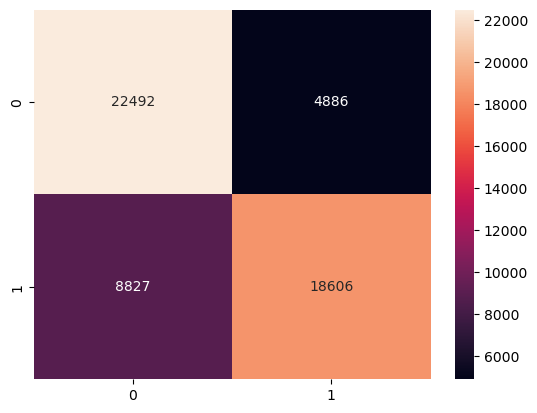

In [63]:
''' Testing outputs for model (placed here so we don't have to retrain)'''
y_pred = loaded_model.predict(X_test)
y_pred = (y_pred > 0.4)

#making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')